
<hr>
<center><h3>Understanding traffic congestion.</h3></center>
<hr>

### Author(s)

- Peter Liem (@prl_23)

from class Thu 7.00pm

### Executive Summary

Data from ride-hailing apps like Grab and GOJEK have generated insights into how congested roads can be. The volume of orders for rides could possibly provide information on the state of congestion at a particular location and timing. These insights are based on the assumption that the entirety of traffic congestion is owed to Grab car services. However, in reality, this should not be the case as traffic congestion can be caused by public and other private transport (e.g. trucks).

Results from this analysis show that while traffic congestions do not necessarily occur almost everywhere, the most serious traffic congestions usually occur in situations where the surrounding areas have a decent level of demand for Grab services. Furthermore, analysis shows that the level of demand for Grab's services is steadily increasing day by day. This is a case for concern as it may reflect the growing severity of traffic congestion. Additionally, demand for Grab's services tend to be varied. This means that on a day perspective, it is hard to predict the severity of traffic congestion. However, what can be predicted easily are the time periods of a day when traffic congestion is expected to be the highest and lowest.

### Research Topic & Hypothesis

We will be studying how traffic congestion occurs in South-East Asia. There is a general consensus that peak traffic congestion would occur in the mornings (7am - 9am) and afternoons (11am - 1pm). Furthermore, there are some claims that traffic congestion is widespread throughout. Based on the data collected by Grab, we can gain an understanding of the road patterns and hence, verify those general beliefs.

**Literature / Articles (where necessary):**
- Commentary: Ride-sharing should reduce congestion, not increase it. ([Link](https://www.channelnewsasia.com/news/commentary/ride-sharing-singapore-congestion-traffic-drivers-grab-go-jek-11438294)) retrieved on 19 Jun 2019

**Datasets used:**
- "Demand Data" by Grab ([Link](https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip)) retrieved on 19 Jun 2019



In [1]:
import folium
from folium import plugins
import pygeohash as pgh
import geohash_hilbert as ghh

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## Data Exploratory Section

Exploring the data.

In [2]:
df = pd.read_csv('training.csv')

In [3]:
print(df.info())
print("-------")
print(df.describe())
print("-------")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB
None
-------
                day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00
-------
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468


In [4]:
# Check for null values
df[df.isnull().any(axis=1)]

# No null values.

,geohash6,day,timestamp,demand


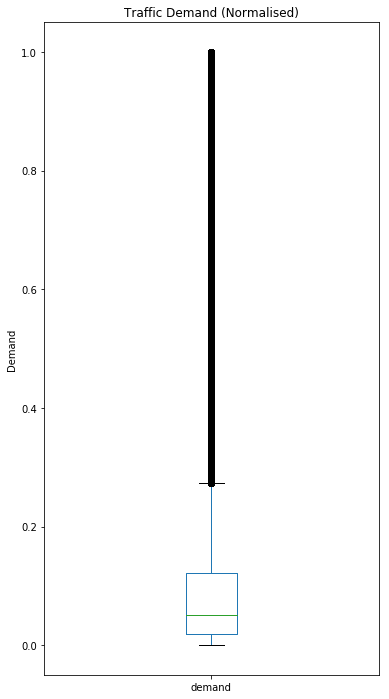

In [5]:
# Examinng the distribution.

fig = plt.figure()
ax = fig.add_subplot(111)

df['demand'].plot(kind = 'box', title = 'Traffic Demand (Normalised)', figsize = (6, 12))

ax.set_ylabel("Demand")

plt.show()

# Plenty of outliers. In this case, outliers are not applicable as traffic demand can vary.

In [6]:
# Number of unique values in 'geohash6' column
df['geohash6'].nunique (dropna = True)

1329

# Data Preparation for Geographical Analysis

Preparing data to create visualisations on how demand differs based on geographical locations.

In [7]:
# Counting the number of records for each location.
df_gb_count = df.groupby('geohash6').agg({'day':'count'}).rename(columns = {'day':'No. of Records'}).sort_values(by = 'No. of Records', ascending = False)
df_gb_count.head()

,No. of Records
geohash6,
qp03wz,5846
qp03xw,5846
qp03wf,5846
qp03yb,5846
qp092m,5845


In [8]:
# Finding average demand in location.
df_gb_mean = df.groupby('geohash6').median()

# Dropping 'day' column
df_avg_demand = df_gb_mean.drop(columns = 'day')
df_avg_demand.head()

,demand
geohash6,
qp02yc,0.017395
qp02yf,0.010985
qp02yu,0.022037
qp02yv,0.047163
qp02yy,0.011443


In [9]:
df_new = pd.merge(left = df_gb_count, left_index = True, right = df_avg_demand, right_index = True, how ='inner')
df_new.head()

,No. of Records,demand
geohash6,,
qp03wz,5846,0.705480
qp03xw,5846,0.974465
qp03wf,5846,0.660571
qp03yb,5846,0.780371
qp092m,5845,0.258841


In [10]:
# Checking code

print(df_gb_count['No. of Records']['qp03yb'])
print(df_new['No. of Records']['qp03yb'])
print('-----')
print(df_avg_demand['demand']['qp092m'])
print(df_new['demand']['qp092m'])

# Successful groupby methods.

5846
5846
-----
0.25884104004552144
0.25884104004552144


In [11]:
# Resetting the index:

df_new = df_new.reset_index()
df_new.head()

,geohash6,No. of Records,demand
0,qp03wz,5846,0.705480
1,qp03xw,5846,0.974465
2,qp03wf,5846,0.660571
3,qp03yb,5846,0.780371
4,qp092m,5845,0.258841


## Decoding the Geohash6
Decoding the geohash6 into latitudes and longtitudes.

Note: Given the geohashes are available, a map would be plotted. However, because they are annoymised, a map would not be plotted in this case. Only by subbing in the actual coordinates in this model can the users get a better understanding of the traffic situation.

In [12]:
# Converting geohashes into latitudes and longtitudes

df_list = []

for i in df_new['geohash6']:
    e= ghh.decode (i)
    df_list.append(e)
df_list = pd.DataFrame(df_list, columns =['Latitude', 'Longtitude'])

df_new['Latitude'] = df_list['Latitude']
df_new['Longtitude'] = df_list ['Longtitude']

print(df_new.head())
print(df_new.shape)

  geohash6  No. of Records    demand   Latitude  Longtitude
0   qp03wz            5846  0.705480  22.521286  -36.479759
1   qp03xw            5846  0.974465  22.513046  -36.480446
2   qp03wf            5846  0.660571  22.513046  -36.479759
3   qp03yb            5846  0.780371  22.503433  -36.484566
4   qp092m            5845  0.258841  22.695694  -36.423454
(1329, 5)


# Plotting the Geographical Analysis

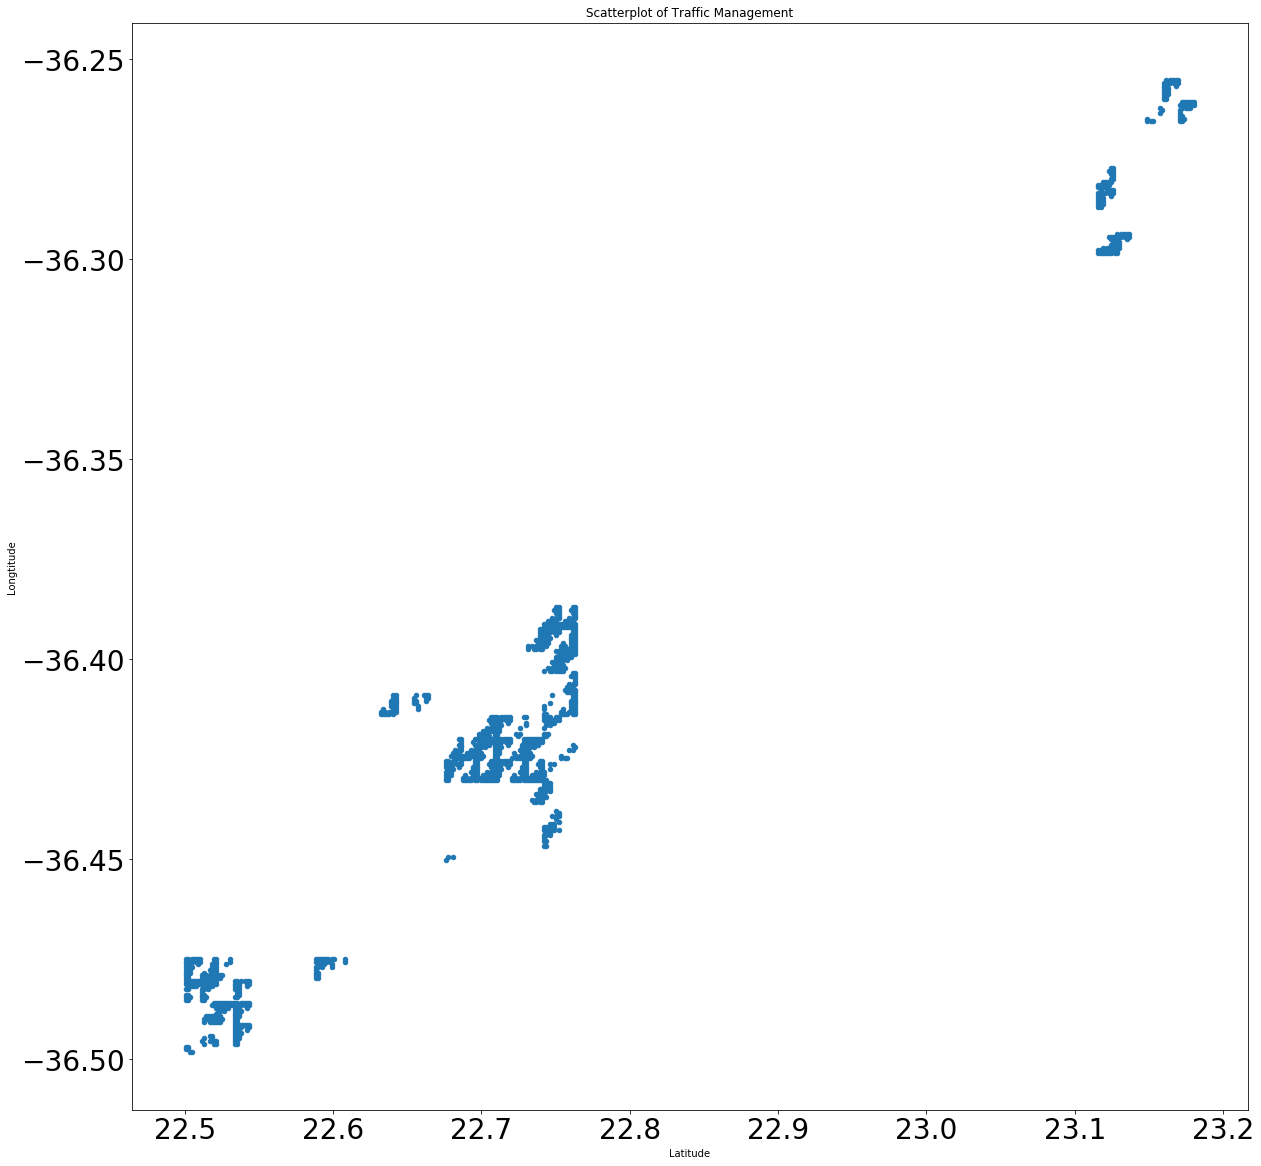

In [13]:
df_new.plot(kind = 'scatter',
            y ='Longtitude', 
            x = 'Latitude', 
            figsize = (20,20), 
            title = 'Scatterplot of Traffic Management', fontsize = 28)

Analysis:

By looking at the plot, we can see three clusters. We should narrow the geographical analysis into each cluster to generate more insights of higher quality.

In [14]:
# Latitude limit: 22.8, Longtitude limit: -36.35

df1 = df_new[(df_new['Latitude'] < 22.62)]

df1.shape

(327, 5)

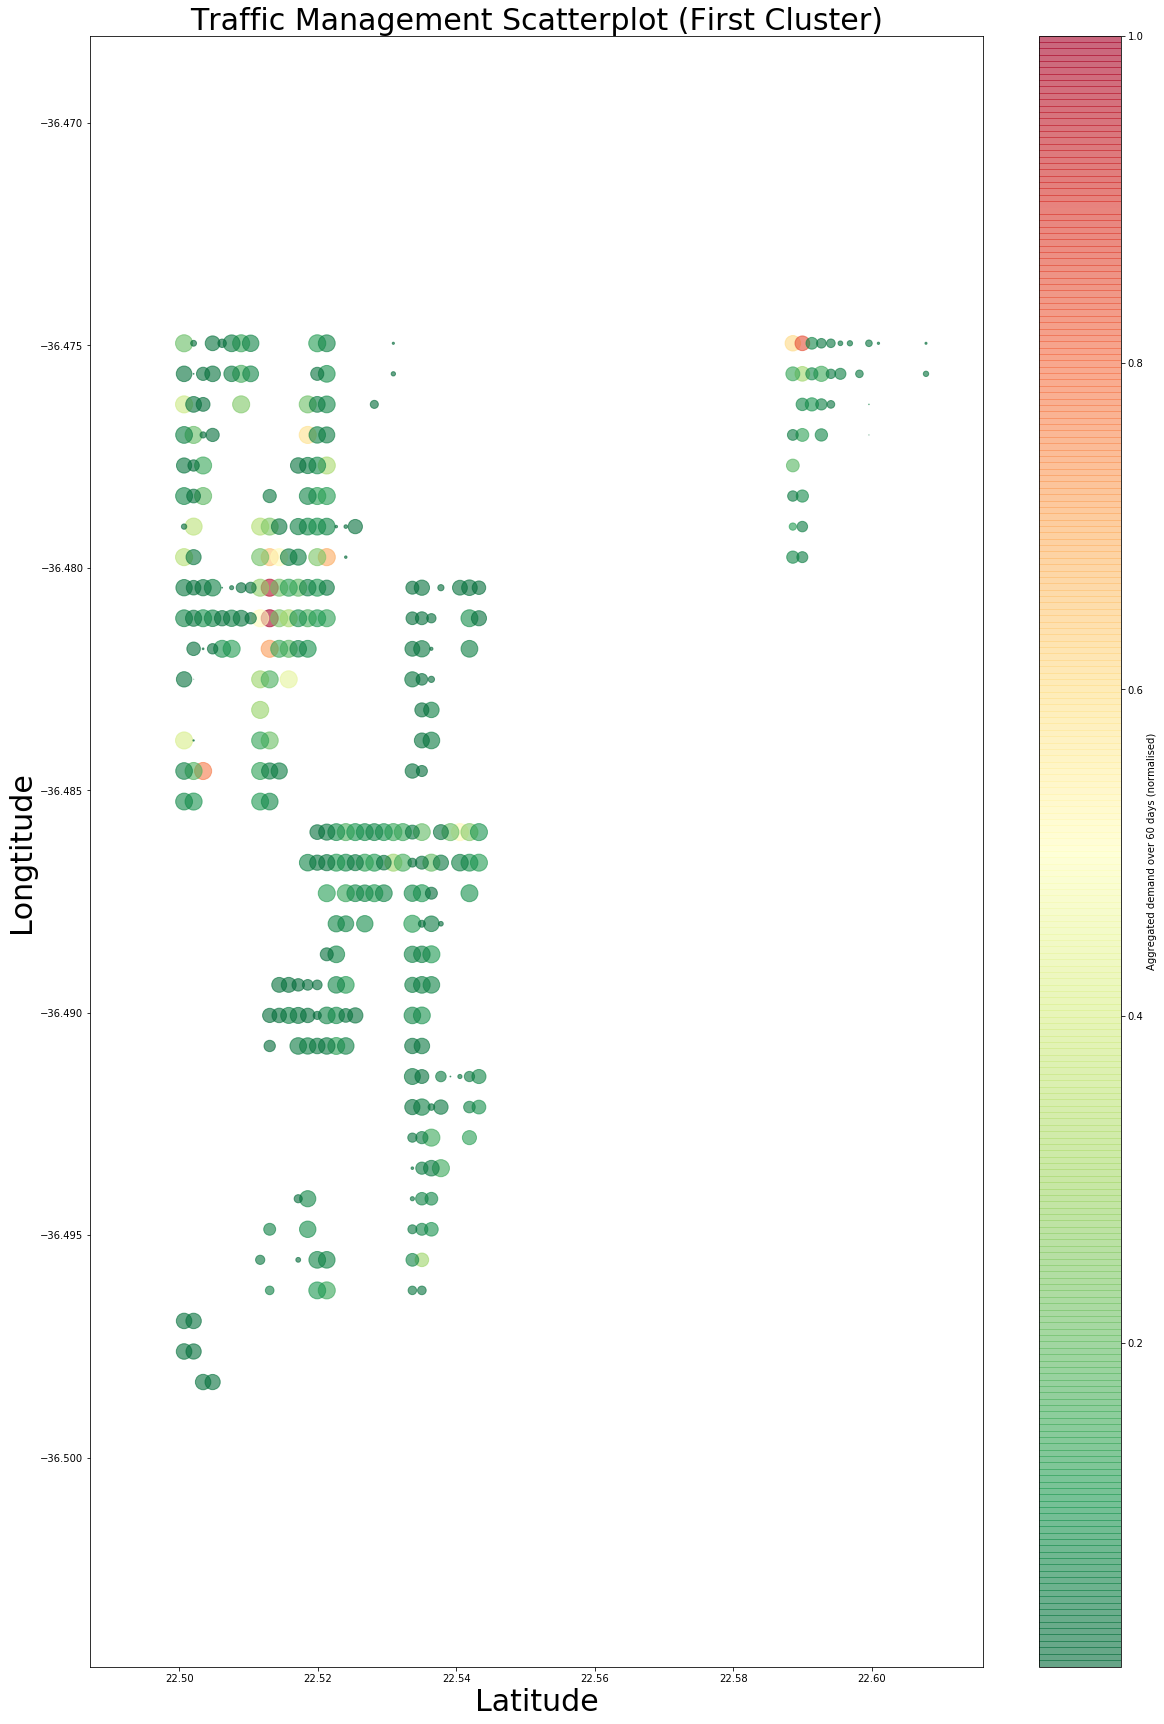

In [84]:
import matplotlib.colors as colors
import matplotlib.cm as cm

# Plotting the first geographical cluster.

x = df1['Latitude']
y = df1['Longtitude']
colours = df1 ['demand']
sizes = 0.05 * df1 ['No. of Records']

plt.scatter (x,
             y, 
             c= colours, cmap = 'RdYlGn_r', 
             s = sizes, 
             alpha = 0.60)
plt.title('Traffic Management Scatterplot (First Cluster)', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.ylabel('Longtitude', fontsize = 30)
plt.colorbar (label = 'Aggregated demand over 60 days (normalised)')
plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

# Size determines number of records in a specific geographical location

We can generally see that the hotspots (red-coloured spots) are surrounded by spots that see a relatively small demand for Grab's services.

In [16]:
# Latitude limit: 22.8, Longtitude limit: -36.35

df2 = df_new[(df_new['Latitude'] <22.8) & (df_new['Latitude'] > 22.62)]

df2.shape

(839, 5)

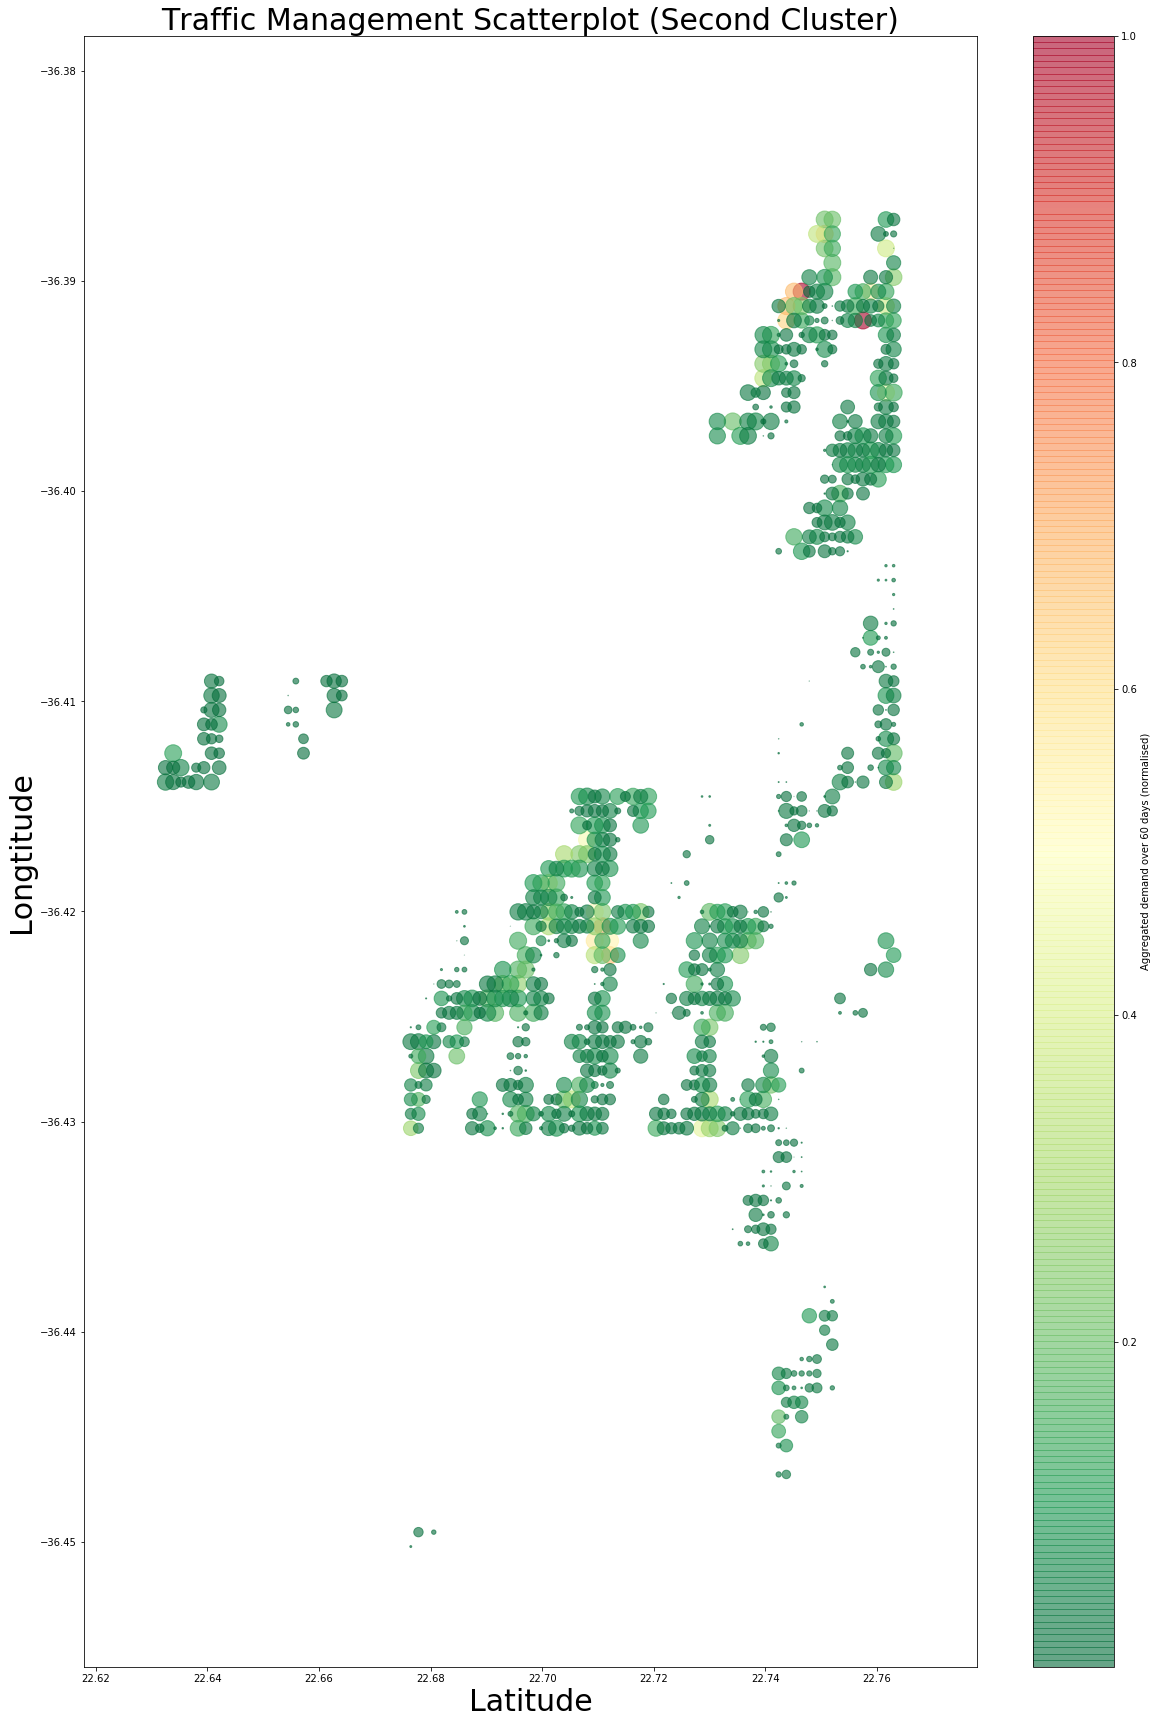

In [17]:
# Plotting the second geographical cluster.

x = df2['Latitude']
y = df2['Longtitude']
colours = df2 ['demand']
sizes = 0.05 * df2 ['No. of Records']

plt.scatter (x,
             y, 
             c= colours, cmap = 'RdYlGn_r', 
             s = sizes, 
             alpha = 0.60)
plt.title('Traffic Management Scatterplot (Second Cluster)', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.ylabel('Longtitude', fontsize = 30)
plt.colorbar (label = 'Aggregated demand over 60 days (normalised)')
plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

# Size determines number of records in a specific geographical location

Again, hotspots (red-coloured spots) can be observed to be surrounded by spots that see a relatively small demand for Grab's services.

In [18]:
# Latitude limit: 22.8, Longtitude limit: -36.35

df3 = df_new[df_new['Latitude'] >22.8]

df3.shape

(163, 5)

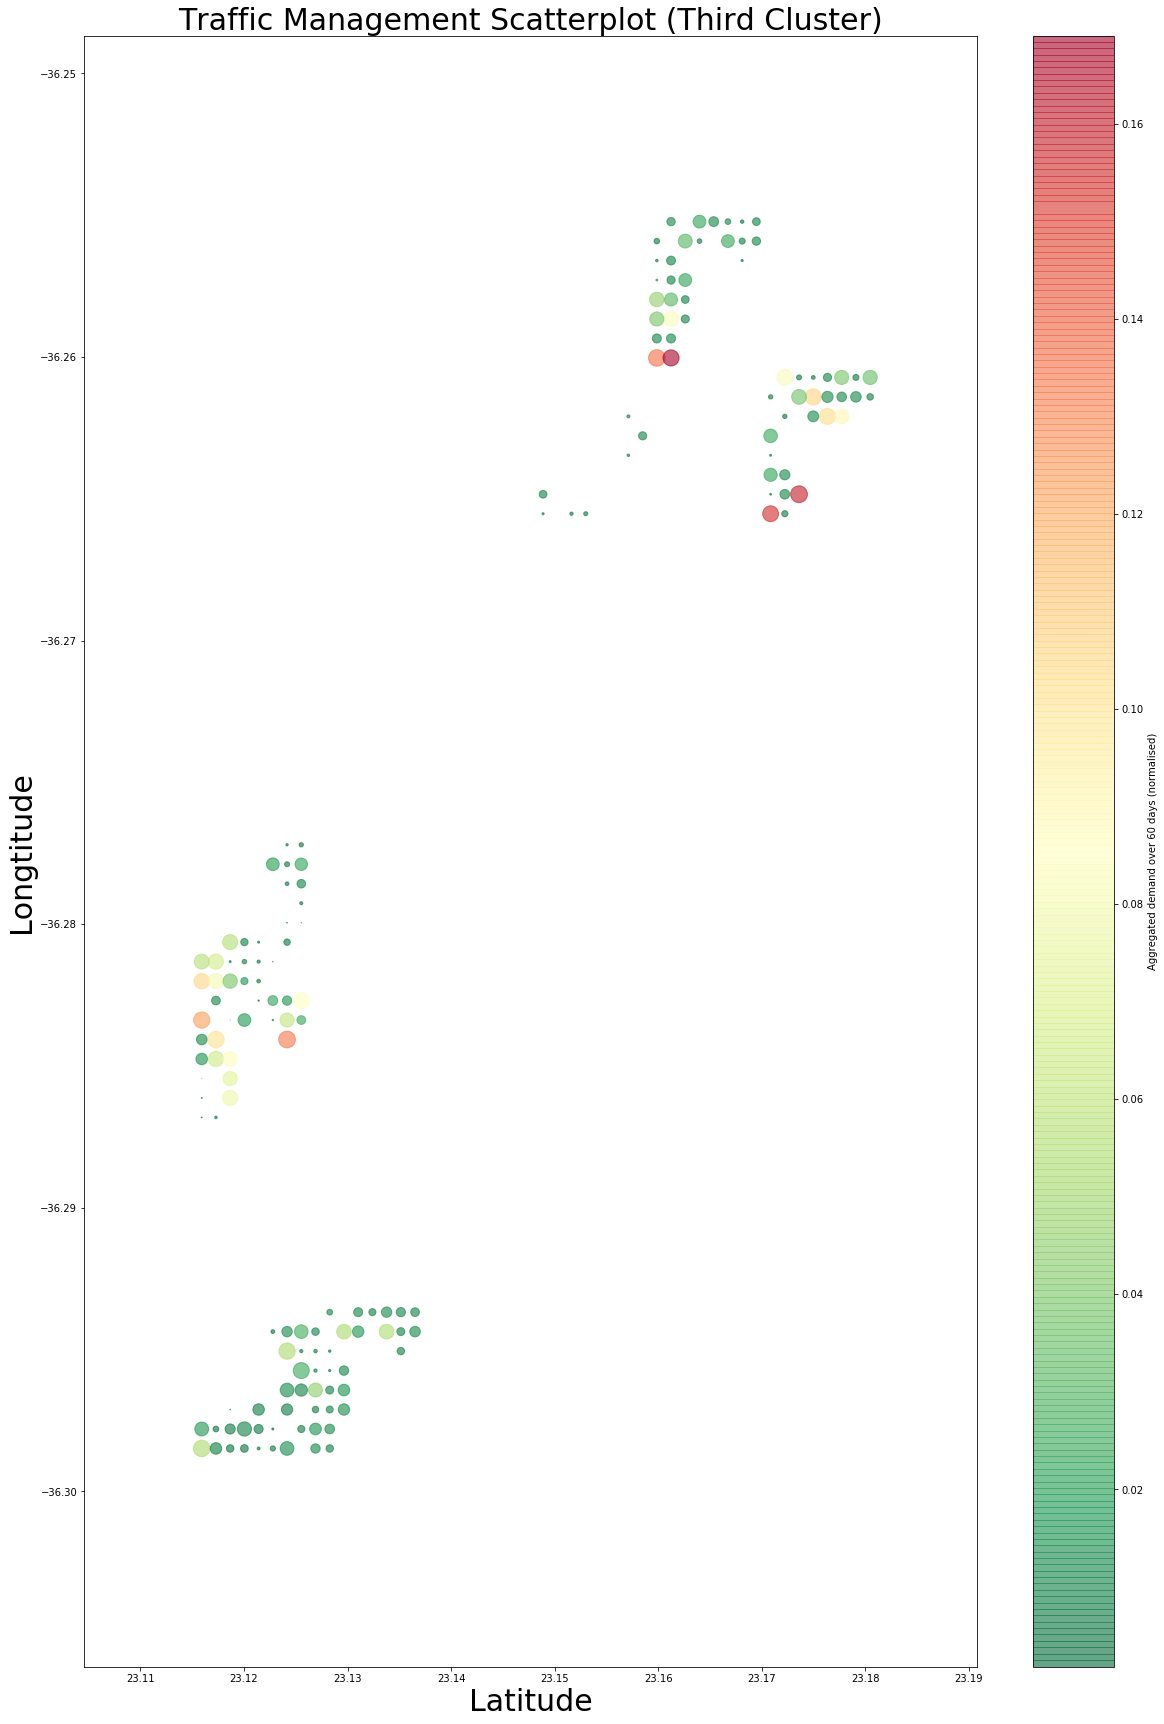

In [19]:
# Plotting the third geographical cluster.

x = df3['Latitude']
y = df3['Longtitude']
colours = df3 ['demand']
sizes = 0.05 * df3 ['No. of Records']

plt.scatter (x,
             y, 
             c= colours, cmap = 'RdYlGn_r', 
             s = sizes, 
             alpha = 0.60)
plt.title('Traffic Management Scatterplot (Third Cluster)', fontsize = 30)
plt.xlabel('Latitude', fontsize = 30)
plt.ylabel('Longtitude', fontsize = 30)
plt.colorbar (label = 'Aggregated demand over 60 days (normalised)')
plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 20, 30

# Size determines number of records in a specific geographical location

This time round the hotspots seem to be further away from those with relatively low demand levels for Grab services than those in the first two clusters. Of all the clusters, the spots here seem to be the most dispersed.

These graphs provide some visual representation of how demand for Grab differ based on geographical locations over 60 days.

# Data Preparation for Time Analysis

Following the geographical visualisation, we move on to find out how demand varies across different days and time periods.

As always, prior to formulating visualisations, data has to be prepared.

As shown above, timestamp is identified as an object. There is a need to convert it into integer types so that it can be used for analysis.

In [30]:
# Making a copy of original dataframe.
df_time = df.copy()

In [31]:
df_time[['hour','min']] = df_time['timestamp'].str.split(':',expand=True)
df_time['hour'] = df_time['hour'].astype('int64')
df_time['min'] = df_time['min'].astype('int64')

df_time.head()

,geohash6,day,timestamp,demand,hour,min
0,qp03wc,18,20:0,0.020072,20,0
1,qp03pn,10,14:30,0.024721,14,30
2,qp09sw,9,6:15,0.102821,6,15
3,qp0991,32,5:0,0.088755,5,0
4,qp090q,15,4:0,0.074468,4,0


In [32]:
df_time_gb = df_time.groupby(['hour','min']).median()
df_time_gb = df_time_gb.drop (columns = 'day')
df_time_gb = df_time_gb.reset_index()
df_time_gb.head()

,hour,min,demand
0,0,0,0.046375
1,0,15,0.047525
2,0,30,0.048717
3,0,45,0.049886
4,1,0,0.051595


In [33]:
# merging the 'hour' and 'min' columns to get a timestamp as float types.

df_time_gb['timestamp'] = df_time_gb['hour'].map(str) + '.' + df_time_gb['min'].map(str)

df_time_gb['timestamp'] = df_time_gb['timestamp'].astype(float)

df_time_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
hour         96 non-null int64
min          96 non-null int64
demand       96 non-null float64
timestamp    96 non-null float64
dtypes: float64(2), int64(2)
memory usage: 3.1 KB


In [34]:
df_day_gb = df.groupby('day').median()
df_day_new = df_day_gb.reset_index()
df_day_new.tail()

,day,demand
56,57,0.052856
57,58,0.051974
58,59,0.053695
59,60,0.059050
60,61,0.055704


In [68]:
week1 = df_day_new[:7] 

# Indexes resetted to help plot a week against week line chart.

week2 = df_day_new[7:14].reset_index()

week3 = df_day_new[15:22].reset_index() 

week4 = df_day_new[23:30].reset_index()

week5 = df_day_new[31:38].reset_index() 

week6 = df_day_new[39:46].reset_index() 

week7 = df_day_new[47:54].reset_index() 

week8 = df_day_new[55:].reset_index()  

# Plotting the Time Analysis

A line chart is built to see how demand differs on a daily basis over the 60-day period.

/Users/Liem/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


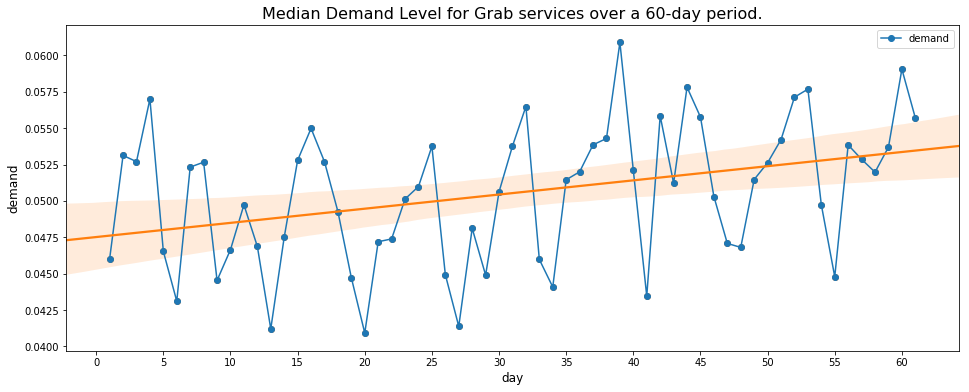

In [69]:
# Plotting line chart of demand against day.

fig = plt.figure(figsize= (16,6))
ax1 = fig.add_subplot(111)

ax1.set_title("Median Demand Level for Grab services over a 60-day period.", fontsize = 16)
df_day_new.plot(kind = 'line', 
                 x = 'day', 
                 y = 'demand', 
                 ax=ax1, 
                 marker = 'o')

plt.xticks(range(0,65,5))
plt.xlabel ('Day', fontsize = 12)
plt.ylabel ('Median Level of Demand (normalised)', fontsize = 12)

# Plotting a trend line.

sns.regplot(x='day',
            y='demand',
            data= df_day_new, 
            fit_reg=True)

Based on the line chart, we can see that the level of demand fluctuates randomly. However, the addition of a trend line shows that the median demand level for Grab services is generally increasing slightly as the days go by. This suggests that the roads are slowly increasingly getting congested.

Text(0,0.5,'Median Level of Demand (normalised)')

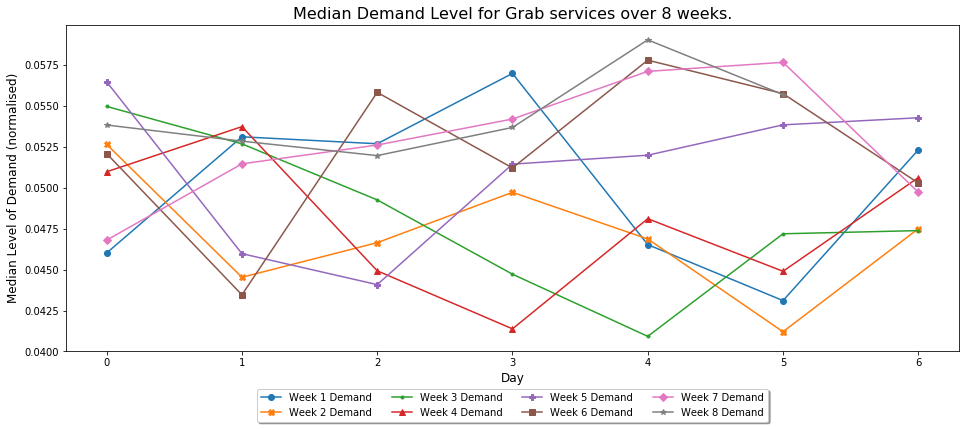

In [81]:
# Plotting a line chart of level of demand for Grab's services across 8 weeks.

fig = plt.figure(figsize= (16,6))
ax2 = fig.add_subplot(111)

ax2.set_title("Median Demand Level for Grab services over 8 weeks.", fontsize = 16)

week1.plot(kind = 'line',  
                 y = 'demand', 
                 ax=ax2, 
                 marker = 'o', 
           label = 'Week 1 Demand')

week2.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = 'X', 
          label = 'Week 2 Demand')

week3.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = '.', 
          label = 'Week 3 Demand')

week4.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = '^', 
          label = 'Week 4 Demand')


week5.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = 'P', 
          label = 'Week 5 Demand')

week6.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = 's', 
          label = 'Week 6 Demand')

week7.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = 'D', 
          label = 'Week 7 Demand')

week8.plot(kind = 'line',
                 y = 'demand', 
                 ax=ax2, 
                 marker = '*', 
          label = 'Week 8 Demand')

ax2.legend(loc='upper center', 
          bbox_to_anchor = (0.5, -0.1), 
          fancybox = True, 
          shadow = True, 
          ncol =4)


plt.xlabel ('Day', fontsize = 12)
plt.ylabel ('Median Level of Demand (normalised)', fontsize = 12)

Based on the comparison chart, we can see that the demand levels for Grab's services in Week 2 are consistently lower than that of the rest of the weeks. Meanwhile, the demand levels for Grab's services in the rest of the weeks are highly varied, with demand levels at some days near the top, and demand levels at other days near the bottom.

Text(0,0.5,'Median Level of Demand (normalised)')

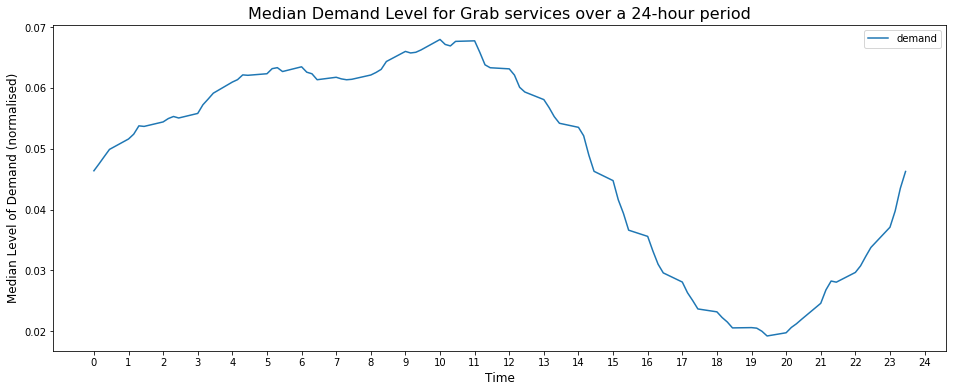

In [83]:
# Plotting line chart of demand against time.

fig = plt.figure(figsize= (16,6))
ax1 = fig.add_subplot(111)

ax1.set_title("Median Demand Level for Grab services over a 24-hour period", fontsize = 16)
df_time_gb.plot(kind = 'line', 
                 x = 'timestamp', 
                 y = 'demand', 
                 ax=ax1)

plt.xticks(range(0, 25))
plt.xlabel ('Time', fontsize = 12)
plt.ylabel ('Median Level of Demand (normalised)', fontsize = 12)


Based on the chart above, the demand level for Grab services generally rises starting from midnight, until its peak in between 1000h and 1100h. After which, the demand level for Grab services is maintained at about 0.068 till 1130h. The demand level then starts to descend rapidly all the way till 1930h. After hitting the trough at 1930h, demand level starts to pick up and increases sharply after 2130h till midnight.

Based on the assumption that Grab services make up all of the traffic congestion in South-East Asia, it can be deduced that traffic congestions are generally already heavy at midnight and peaks in the late morning period (0700h till 1130h). After which, traffic congestion start to clear -- the lowest traffic congestion occurs at 1930h. Subsequently, traffic congestions pick up after 1930h and ascends rapidly all the way to midnight.

However, this analysis is not an accurate representation of traffic congestion. In particular, the demand for Grab services could have spiked in the early morning period (0000h till 0600h) because of the fact that there are no public transport options available at these timings. Instead of expecting heavy road usage, one can expect the roads to be generally empty in the early morning period.

### Insights and Evaluation 

- Geographical location wise: areas that see high levels of demand tend to be surrounded by areas with low levels of demand. 

- Roads are increasingly getting congested day by day.

- On a week-to-week basis, it seems difficult to point out which week had the lowest road congestion. Out of all the weeks, only week 2 faced generally low levels of demand. The rest of the weeks saw very varied levels of demand.

- Peak periods seem to be in the late morning period (0700h till 1130h). Demand levels then drop off after 1130h right till its trough at 1930h. After which, demand levels pick up again. In other words, based on the assumption that traffic congestions are entirely caused by Grab servies, it is best to avoid the roads in the late morning period. The best time period to use the roads would be in the afternoon period -- at least till 1930h.

- Generally this analysis is not representative of traffic congestion: public and other private transport (e.g. trucks) also make up traffic congestion. However, this analysis is sufficient in providing information on how much ride-hailing services take place at certain locations and timings.

### Notes for Instructor

Double click on this cell and remove `hidden="true"`. (Use this if you'd like your report to be a private one and not be shared with anybody)
<p style="color:red" hidden="true"><b>Please do not share the findings of this report.</b></p>

Resources:

    https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas
    https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter
    https://stackoverflow.com/questions/27341971/matplotlib-colormap-in-scatter-plot-attributeerror-unknown-property-size
    https://matplotlib.org/users/colormaps.html
    https://alysivji.github.io/getting-started-with-folium.html